# Specify Paths

In [68]:
out_dir = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/ccm_memory/results/control_analyses/cmn_vs_others'


In [69]:
# Specify the path to your CSV file containing NIFTI paths
input_csv_path = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/ccm_memory/metadata/comparison_of_maps/damage_to_target_correlated_to_memory_paired_targets.csv'
sheet=None

# 00 - Import CSV with All Data
**The CSV is expected to be in this format**
- ID and absolute paths to niftis are critical
```
+-----+----------------------------+--------------+--------------+--------------+
| ID  | Nifti_File_Path            | Covariate_1  | Covariate_2  | Covariate_3  |
+-----+----------------------------+--------------+--------------+--------------+
| 1   | /path/to/file1.nii.gz      | 0.5          | 1.2          | 3.4          |
| 2   | /path/to/file2.nii.gz      | 0.7          | 1.4          | 3.1          |
| 3   | /path/to/file3.nii.gz      | 0.6          | 1.5          | 3.5          |
| 4   | /path/to/file4.nii.gz      | 0.9          | 1.1          | 3.2          |
| ... | ...                        | ...          | ...          | ...          |
+-----+----------------------------+--------------+--------------+--------------+
```

# Import Relevant Information

In [70]:
from calvin_utils.permutation_analysis_utils.statsmodels_palm import CalvinStatsmodelsPalm
# Instantiate the PalmPrepararation class. Enter value for sheet if you are using an Excel spreadsheet.
cal_palm = CalvinStatsmodelsPalm(input_csv_path=input_csv_path, output_dir=out_dir, sheet=sheet)
# Call the process_nifti_paths method
data_df = cal_palm.read_and_display_data()
data_df

,idx,Lesion_Specific,DBS_Specific,TMS_Specific,Convergent_Memory_Map_Lesions,Convergent_Memory_Map_DBS,Convergent_Memory_Map_TMS
0,1,-0.12,0.04,0.27,0.15,-0.30,-0.27
1,2,-0.23,0.08,0.15,0.30,-0.16,-0.39
2,3,-0.22,0.06,0.25,0.28,-0.11,-0.39
3,4,-0.16,0.06,0.07,0.19,-0.05,0.12


**Handle NANs**
- Set drop_nans=True is you would like to remove NaNs from data
- Provide a column name or a list of column names to remove NaNs from

In [56]:
data_df.columns

Index(['idx', 'Lesion_Specific', 'DBS_Specific', 'TMS_Specific',
       'Convergent_Memory_Map_Lesions', 'Convergent_Memory_Map_DBS',
       'Convergent_Memory_Map_TMS'],
      dtype='object')

In [34]:
drop_list = ['Z_Scored_Percent_Cognitive_Improvement', 'Subiculum_Group_By_24', 'City', 'Age_Group']

In [ ]:
data_df = cal_palm.drop_nans_from_columns(columns_to_drop_from=drop_list)
display(data_df)

**Drop Row Based on Value of Column**

Define the column, condition, and value for dropping rows
- column = 'your_column_name'
- condition = 'above'  # Options: 'equal', 'above', 'below'

Set the parameters for dropping rows

In [ ]:
data_df.columns

In [ ]:
column = 'Cohort'  # The column you'd like to evaluate
condition = 'equal'  # Thecondition to check ('equal', 'above', 'below', 'not')
value = 3  # The value to compare against

In [ ]:
data_df, other_df = cal_palm.drop_rows_based_on_value(column, condition, value)
data_df

**Data Transformations**


A) Standardize Data

In [ ]:
# Remove anything you don't want to standardize
cols_not_to_standardize = ['Z_Scored_Percent_Cognitive_Improvement', 'Z_Scored_Subiculum_Connectivity']

In [ ]:
data_df = cal_palm.standardize_columns(cols_not_to_standardize)
data_df

B) Normalize Data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Normalize each factor using Min-Max scaling
scaler = MinMaxScaler(feature_range=(-1,1))
for col in data_df.columns:
    try:
        data_df[col] = scaler.fit_transform(data_df[[col]])
    except:
        pass

Recompose a new Dataframe if Needed

In [ ]:
# Function to add columns based on condition
import numpy as np
def add_columns_based_on_condition(df, condition_col, condition, suffix):
    for col in df.columns:
        if col != condition_col:  # Skip the condition column itself
            # Create a new column name by appending the suffix
            new_col_name = f"{col}{suffix}"
            
            # Apply condition; set value in new column if condition is met, otherwise set to NaN
            df[new_col_name] = df.apply(lambda x: x[col] if x[condition_col] != condition else np.nan, axis=1)
    
    # Optional: You can drop the original columns if they are no longer needed
    # df.drop(columns=df.columns.difference([condition_col] + df.filter(like=suffix).columns.tolist()), inplace=True)
    
    return df

In [ ]:
data_df.columns

In [ ]:
# Apply the function to your DataFrame
data_df = add_columns_based_on_condition(data_df, condition_col='Disease_Status', condition='Normal', suffix='_c')
data_df

**Pivot DF If needed**

In [ ]:
def pivot_dataframe(df, concat_col, category_col):
    # Create a new DataFrame where each unique category becomes a column
    # and the values from concat_col are listed under these category columns
    # First, ensure that the index is reset for the DataFrame to avoid issues during pivoting
    df.reset_index(drop=True, inplace=True)

    # Create a new DataFrame where each row will have the category as a column and the corresponding values
    # from concat_col under that category
    pivoted_df = df.pivot(columns=category_col, values=concat_col)
    
    return pivoted_df

In [ ]:
data_df.columns

In [ ]:
pdf = pivot_dataframe(data_df, 'Z_Scored_Percent_Cognitive_Improvement_residual','Age_Group')
pdf

Regress out a Covariate

In [ ]:
from calvin_utils.statistical_utils.regression_utils import RegressOutCovariates
# use this code block to regress out covariates. Generally better to just include as covariates in a model..
dependent_variable_list = ['Z_Scored_Percent_Cognitive_Improvement']
regressors = ['Subiculum_Connectivity_T_Redone']

data_df, adjusted_dep_vars_list = RegressOutCovariates.run(df=data_df, dependent_variable_list=dependent_variable_list, covariates_list=regressors)

# Descriptive Stats

In [ ]:
data_df.describe()

In [ ]:
0.79 / 20**.5

In [ ]:
pdf.describe()

In [ ]:
data_df.columns

In [ ]:
data_df['Total'].median()

# Descriptive Plot

In [ ]:
import seaborn as sns
sns.pairplot(data_df)

# Visualize in 2D

In [ ]:
y_axis = 'Randomization_Group'
x_axis = 'Age'

In [ ]:
import seaborn as sns
sns.scatterplot(data=data_df, x=x_axis, y=y_axis)

# Visualize Data in 3D

In [ ]:
import plotly.express as px

def generate_scatterplot(dataframe, data_dict, correlation, palette, out_dir):
    """
    Generates a 3D scatter plot from the given DataFrame and saves it to the specified directory.

    Parameters:
    - dataframe: pandas DataFrame containing the data.
    - data_dict: Dictionary with one key-value pair, where the key is the dependent variable 
                 and the value is a list of independent variables (length should be 2 for 3D scatter).
    - x_label, y_label, z_label: Labels for the x, y, and z axes.
    - correlation: Whether to display correlation information on the plot (True/False).
    - palette: Color palette for the plot.
    - out_dir: Directory path where the plot image will be saved.
    """
    dependent_var = list(data_dict.keys())[0]
    independent_vars = data_dict[dependent_var]

    if len(independent_vars) != 2:
        raise ValueError("Independent variable list must contain exactly two elements for 3D scatter plot.")

    fig = px.scatter_3d(dataframe, x=independent_vars[0], y=independent_vars[1], z=dependent_var,
                        color=dependent_var, color_continuous_scale=palette)

    # Set the labels
    fig.update_layout(scene=dict(
        xaxis_title=independent_vars[0],
        yaxis_title=independent_vars[1],
        zaxis_title=dependent_var
    ))

    # Optionally, add correlation info as annotation
    if correlation:
        # Compute and display correlation (requires additional implementation)
        pass

    # Save the plot to the output directory
    fig.write_image(f"{out_dir}/3d_scatter_plot.png")

    return fig

In [ ]:
data_df.columns

In [ ]:
data_dict = {'Cognitive_Status_Code': ['Convolutional_Neural_Network']}

In [ ]:
# Example usage
plot = generate_scatterplot(dataframe=data_df, 
                            data_dict=data_dict,
                            correlation=True,
                            palette='Reds',
                            out_dir=out_dir)
plot

In [ ]:
display(data_df[(data_df['Cognitive_Status_Code'] == 0) & (data_df['Convolutional_Neural_Network'] == 8)])


# Compare Distributions


Input columns to test like this:
- group1_col_name = 'Alzheimer'

In [71]:
data_df.columns

Index(['idx', 'Lesion_Specific', 'DBS_Specific', 'TMS_Specific',
       'Convergent_Memory_Map_Lesions', 'Convergent_Memory_Map_DBS',
       'Convergent_Memory_Map_TMS'],
      dtype='object')

In [72]:
for col in data_df.columns:
    data_df[col] = (data_df[col]**2)**.5
data_df

,idx,Lesion_Specific,DBS_Specific,TMS_Specific,Convergent_Memory_Map_Lesions,Convergent_Memory_Map_DBS,Convergent_Memory_Map_TMS
0,1.0,0.12,0.04,0.27,0.15,0.30,0.27
1,2.0,0.23,0.08,0.15,0.30,0.16,0.39
2,3.0,0.22,0.06,0.25,0.28,0.11,0.39
3,4.0,0.16,0.06,0.07,0.19,0.05,0.12


In [76]:
group1_col_name = 'Lesion_Specific'
group2_col_name = 'Convergent_Memory_Map_Lesions'
x_label = 'Network'
y_label = 'R-Squared'
test_type = 't-test_ind'

In [77]:
data_df

,idx,Lesion_Specific,DBS_Specific,TMS_Specific,Convergent_Memory_Map_Lesions,Convergent_Memory_Map_DBS,Convergent_Memory_Map_TMS
0,1.0,0.12,0.04,0.27,0.15,0.30,0.27
1,2.0,0.23,0.08,0.15,0.30,0.16,0.39
2,3.0,0.22,0.06,0.25,0.28,0.11,0.39
3,4.0,0.16,0.06,0.07,0.19,0.05,0.12


Figure saved to:  /Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/ccm_memory/results/control_analyses/cmn_vs_others/distribution_figures/validation/Network_t-test_ind_R-Squared


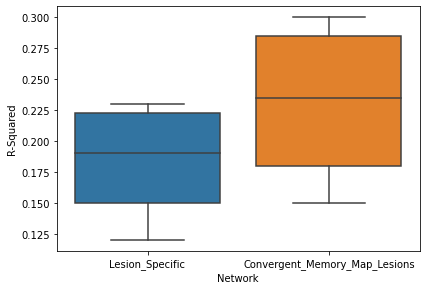

In [78]:
import os
import seaborn as sns
from calvin_utils.statistical_utils.distribution_statistics import plot_with_annotation
plt = plot_with_annotation(dataframe=data_df, 
                           col1=group1_col_name, 
                           col2=group2_col_name,
                           xlabel=x_label, 
                           ylabel=y_label, 
                           test_type=test_type,
                           colours=sns.set_palette('tab10')
)

os.makedirs(os.path.join(out_dir, 'distribution_figures/validation'), exist_ok=True)
plt.savefig(os.path.join(out_dir, f'distribution_figures/validation/{x_label}_{test_type}_{y_label}.png'))
plt.savefig(os.path.join(out_dir, f'distribution_figures/validation/{x_label}_{test_type}_{y_label}.svg'))
print('Figure saved to: ', (os.path.join(out_dir, f'distribution_figures/validation/{x_label}_{test_type}_{y_label}')))

Perform Multiple Distribution Tests and Correct for Multiple Comparisons

Below is a detailed description of the `plot_distribution_tests` function.

### `plot_distribution_tests` Function

This function creates a plot of distribution tests with optional annotations for multiple key-value pair comparisons.

#### Parameters

- `dataframe`: A pandas DataFrame containing the data for comparison.
- `comparisons_dict`: A dictionary mapping comparisons with keys and values representing column names in the DataFrame.
- `test_type`: Specifies the statistical method used for testing. Available options are:
  - `'t-test_ind'`: Independent t-test
  - `'t-test_paired'`: Paired t-test
  - `'Mann-Whitney'`: Mann-Whitney U test
  - `'Wilcoxon'`: Wilcoxon signed-rank test
- `correction_method`: Specifies the method used to correct for multiple comparisons. Available options are:
  - `'bonferroni'`: Bonferroni correction
  - `'holm'`: Holm's correction
  - `'fdr_bh'`: Benjamini-Hochberg false discovery rate correction
- `key_label`: A string label for the keys in the plot.
- `value_label`: A string label for the values in the plot.
- `x_label`: Label for the x-axis.
- `y_label`: Label for the y-axis.
- `display`: Controls how the keys and values are displayed. Available options are:
  - `'split_pairs'`: Displays keys and values side by side, with keys on the left and values on the right.
  - `'group_pairs'`: Groups the key-value pairs together.
- `full_legend_patches`: A boolean that controls the appearance of the legend. If `True`, full key-value pairs are shown in the legend; if `False`, only keys are shown.
```

In [ ]:
from statannotations.Annotator import Annotator
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os

def plot_distribution_tests(dataframe, comparisons_dict, test_type, correction_method, key_label, value_label, x_label, y_label, display='split_pairs', full_legend_patches=False):
    valid_tests = ['t-test_ind', 't-test_paired', 'Mann-Whitney', 'Wilcoxon']
    valid_corrections = ['bonferroni', 'holm', 'fdr_bh']
    if test_type not in valid_tests:
        raise ValueError(f"Invalid test type. Choose from: {', '.join(valid_tests)}")
    if correction_method not in valid_corrections:
        raise ValueError(f"Invalid correction method. Choose from: {', '.join(valid_corrections)}")

    # Create a color palette with enough unique colors
    colors = sns.color_palette("tab10", len(comparisons_dict))

    # Create a new DataFrame to hold the data for plotting
    data = pd.DataFrame(columns=['GroupType', 'Metric', 'Value'])
    pairs = []
    # Create legend patches
    legend_patches = []

    # Iterate through comparisons_dict
    for idx, (key, value) in enumerate(comparisons_dict.items()):
        key_series = dataframe[key]
        value_series = dataframe[value]
        color = colors[idx]
        temp_data = pd.DataFrame({
            'GroupType': [f'Key'] * len(key_series) + [f'Value'] * len(value_series),
            'Metric': [key] * len(key_series) + [value] * len(value_series),
            'Value': key_series.tolist() + value_series.tolist(),
            'Color': [color] * (len(key_series) + len(value_series))
        })
        data = pd.concat([data, temp_data], axis=0)
        pairs.append(((key, 'Key'), (value, 'Value')))
        
        if full_legend_patches:
            legend_patches.append(mpatches.Patch(color=colors[idx], label=f'{key} vs {value}'))
        else:
            legend_patches.append(mpatches.Patch(color=colors[idx], label=f'{value}'))

    # Map colour
    palette_mapping = {row['Metric']: row['Color'] for _, row in data.iterrows()}

    # Create figure
    fig, ax = plt.subplots(figsize=(len(comparisons_dict)*1.3, 5))
    # Add annotations
    if display=='group_pairs':
        # Plot with seaborn (split image)
        sns.set_style('white')
        palette = sns.color_palette('tab10', 2, desat=1)  # Define palette with 2 colors
        sns.set_palette(palette)
        ax = sns.boxplot(x='Metric', y='Value', hue='GroupType', data=data, ax=ax, palette=palette)
        
        # Define the Legend
        key_color = palette[0]  # Color for the 'Key' group
        value_color = palette[1]  # Color for the 'Value' group
        legend_patches = [mpatches.Patch(color=key_color, label=key_label),
                        mpatches.Patch(color=value_color, label=value_label)]
        
        # Add annotations
        annotator = Annotator(ax=ax,
                              data=data,
                              x='Metric',
                              y='Value',
                              hue='GroupType',
                              pairs=pairs,
                              test=test_type,
                              text_format='full',
                              loc='inside',
                              verbose=2)
        x_labels = [pair[0][0] for pair in pairs]
        result = [' '] * (len(x_labels) * 2)
        result[0::2] = x_labels
        x_labels = result
        x_ticks = [i for i in range(0, len(pairs)*2)]
        plt.xticks(ticks=x_ticks, labels=x_labels)
    elif display=='split_pairs':
        # Plot with seaborn (side-by-side)
        ax = sns.boxplot(x='GroupType', y='Value', hue='Metric', data=data, ax=ax, palette={row['Metric']: row['Color'] for _, row in data.iterrows()})
        # Adjust pairs for side-by-side
        pairs = [(('Key', col1), ('Value', col2)) for col1, col2 in comparisons_dict.items()]
        # Add annotations
        annotator = Annotator(ax=ax,
                              data=data,
                              x='GroupType',
                              y='Value',
                              hue='Metric',
                              pairs=pairs,
                              test=test_type,
                              text_format='full',
                              loc='outside',
                              verbose=1)
        x_labels = [key_label] + [value_label]
        plt.xticks(ticks=range(len(x_labels)), labels=x_labels)
    else:
        raise ValueError(f'display {display} not supported please choose "split_pairs" or "group_pairs"')

    # Configure and annotate
    _, corrected_results = annotator.configure(test=test_type, comparisons_correction=correction_method).apply_and_annotate()

    # Label and show plot
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.title(f'Distribution Test: {test_type} with {correction_method} correction')
    plt.legend(handles=legend_patches, frameon=False, loc=(0.025, 0.05))

    return plt

In [ ]:
data_df.columns

In [ ]:
comparisons_dict = {'Convolutional_Neural_Network':'Convolutional_Neural_Network_Equivalent', 
                    'Natural_Language_Processing':'Natural_Language_Processing_Equivalent', 
                    'Expert_Algorithm':'Expert_Algorithm_Equivalent'}

In [ ]:
# comparisons_dict = {'ACE3_Question_2': 'Question_2', 'ACE3_Question_3': 'Question_3', 'ACE3_Question_4': 'Question_4', 'ACE3_Question_5': 'Question_5', 'ACE3_Question_6': 'Question_6', 'ACE3_Question_7': 'Question_7', 'ACE3_Question_8': 'Question_8', 'ACE3_Question_9': 'Question_9', 'ACE3_Question_10': 'Question_10', 'ACE3_Question_11': 'Question_11', 'ACE3_Question_12': 'Question_12', 'ACE3_Question_13': 'Question_13', 'ACE3_Question_14': 'Question_14', 'ACE3_Question_15': 'Question_15', 'ACE3_Question_16': 'Question_16', 'ACE3_Question_17': 'Question_17', 'ACE3_Question_18': 'Question_18', 'ACE3_Question_19': 'Question_19', 'ACE3_Question_20': 'Question_20'}
test_type = 'Mann-Whitney'
correction_method = 'bonferroni'
key_label = 'ACoE'
value_label = 'ACE3'
x_label = 'Test'
y_label = 'Score'

#----------------------------------------------------------------
plt = plot_distribution_tests(dataframe=data_df,
                        comparisons_dict=comparisons_dict, 
                        test_type=test_type, 
                        correction_method=correction_method,
                        key_label=key_label, 
                        value_label=value_label, 
                        x_label=x_label, 
                        y_label=y_label,
                        display='group_pairs')
plt

os.makedirs(os.path.join(out_dir, 'distribution_figures'), exist_ok=True)
plt.savefig(os.path.join(out_dir, f'distribution_figures/{test_type}_{correction_method}_multiple_comparison_barplot.png'))
plt.savefig(os.path.join(out_dir, f'distribution_figures/{test_type}_{correction_method}_multiple_comparison_barplot_barplot.svg'))
print('Figure saved to: ', (os.path.join(out_dir, f'icc_figures/{test_type}_{correction_method}_multiple_comparison_barplot')))

In [ ]:
data_df['ParietalWM_AD']

# Measures of Correlation

Spearman/Pearson Correlation

In [ ]:
import pandas as pd
import seaborn as sns
from scipy.stats import spearmanr, pearsonr, kendalltau
from natsort import index_natsorted

# Correcting the function to remove natural sorting and ensure DataFrame is passed

def generate_scatterplot(dataframe, data_dict, columns_per_row=3, x_label='xlabel', y_label='ylabel', correlation='pearson', palette='Greys'):
    '''
    Generate scatterplots with specified correlation coefficient annotated.

    :param dataframe: DataFrame containing the data
    :param data_dict: Dictionary where key is the dependent variable name, and value is a list of independent variable names
    :param columns_per_row: Number of columns per row in the facet plot
    :param x_label: Label for the x-axis
    :param y_label: Label for the y-axis
    :param correlation: method of correlation ('pearson', 'spearman', 'kendall')
    :return: Facet plot
    '''
    sns.set_style('white')
    sns.set_palette(palette, 1, desat=1)
    
    for dependent_var, independent_vars in data_dict.items():
        # Melt the DataFrame for each dependent variable
        melted_df = pd.melt(dataframe, id_vars=[dependent_var], value_vars=independent_vars,
                            var_name='independent_variable_name', value_name='independent_variable_units')

        # Sort the DataFrame
        melted_df = melted_df.sort_values(by='independent_variable_name')

        # Begin plotting
        facet_plot = sns.lmplot(y=dependent_var, x='independent_variable_units', data=melted_df,
                                col='independent_variable_name', truncate=False, col_wrap=columns_per_row,
                                facet_kws=dict(sharex=False, sharey=True))

        # Calculate correlation for each cluster
        grouped_df = melted_df.groupby('independent_variable_name')
        
        if correlation == 'pearson':
            result = grouped_df.apply(lambda x: pearsonr(x['independent_variable_units'], x[dependent_var]))
        elif correlation == 'spearman':
            result = grouped_df.apply(lambda x: spearmanr(x['independent_variable_units'], x[dependent_var]))
        elif correlation == 'kendall':
            result = grouped_df.apply(lambda x: kendalltau(x['independent_variable_units'], x[dependent_var]))
        else:
            raise ValueError(f'Correlation {correlation} not specified, please select "pearson", "kendall" or "spearman"')

        # Annotate with correlation
        for ax in facet_plot.axes:
            # Get the title of the current subplot
            region = ax.get_title().split("=")[-1].strip()
            # Get the corresponding r, p values from the result
            r, p = result[region]
            ax.set_title(region)
            ax.annotate(f"r = {r:.2f}, p = {p:.5f}", xy=(.5, 1.0), xycoords='axes fraction',
                        xytext=(0, 0), textcoords='offset points', ha='center', va='top',
                        bbox=dict(boxstyle='round,pad=0.0', alpha=0.0),
                        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
            
        facet_plot.set_xlabels(x_label)
        facet_plot.set_ylabels(y_label)
        return facet_plot



In [ ]:
data_df.columns

In [ ]:
columns_to_correlate_to = 'ventricleVisualCH'
columns_to_correlate_list = ['ventricleVisualCH', 'SubcortexCSF',
       'SubcortexCSFCount', 'SubcortexGM', 'SubcortexGMCount', 'SubcortexWM',
       'SubcortexWMCount']
x_label = 'exploratory_measure'
y_label = columns_to_correlate_to
correlation = 'pearson'

#---------
plot = generate_scatterplot(dataframe=data_df, 
                     data_dict={columns_to_correlate_to:columns_to_correlate_list}, 
                     x_label=x_label, 
                     y_label=y_label,
                     correlation=correlation,
                     palette='Greys')

import os
os.makedirs(os.path.join(out_dir, 'scatterplot_figures'), exist_ok=True)
plot.savefig(os.path.join(out_dir, f'scatterplot_figures/{x_label}_to_{y_label}.png'))
plot.savefig(os.path.join(out_dir, f'scatterplot_figures/{x_label}_to_{y_label}.svg'))
print('Figure saved to: ', (os.path.join(out_dir, f'scatterplot_figures/{x_label}_to_{y_label}')))

**Test Split Between Correlation of Variables**

The ScatterWithConfidence class is designed to generate scatter plots with associated confidence intervals and permutation-based p-values. It creates plots of two variables and segregates them by a specified criterion, such as age. These plots are further enhanced by overlaying regression lines with their associated confidence intervals. The class can also perform permutation tests to compute a p-value, which is then prominently displayed in the plot title.

Attributes:
data_df (pandas.DataFrame): The main dataframe containing the data intended for plotting.
Key Methods:
1. compute_analytic_confidence_interval(x, y, x_vals)
Purpose: Computes the regression line and its 95% confidence intervals using analytic methods.
Parameters:
x (pandas.Series): The x-values of the data.
y (pandas.Series): The y-values of the data.
x_vals (numpy.ndarray): The x-values where the regression line and confidence intervals should be computed.
Returns:
y_fit: Regression line values.
lower_bound: Lower 95% confidence interval.
upper_bound: Upper 95% confidence interval.
2. permute_data_and_difference_in_pearson_r(...)
Purpose: Computes the difference in Pearson R between two groups using permutation tests.
Parameters:
x_one, x_two (str): Column names of the two variables to be correlated.
split_by (str): Column name used to segregate the data.
split_value (float): The criterion value for data segregation.
n_permutations (int, optional): Number of permutations to perform (default is 1000).
permute_columns (list of str, optional): List of column names to be permuted.
Returns:
original_diff: Difference in Pearson R of the original data between two groups.
p_value: Permutation-based p-value.
3. plot_with_analytic_ci_manual_pvalue(...)
Purpose: Generates a scatter plot with regression lines, confidence intervals, and the permutation-based p-value in the title.
Parameters:
x_one, x_two (str): Column names of the two variables for plotting.
split_by (str): Column name for data segregation.
... (Other parameters for customization, saving, etc.)
Returns:
A matplotlib scatter plot.
To utilize this class:

Initialize the class with your dataset.
Use the methods described above to compute confidence intervals or perform permutation tests.
Generate and visualize your enhanced scatter plot using the provided methods.
Example:

python
Copy code
scatter_plotter = ScatterWithConfidence(data_df)
scatter_plotter.plot_with_analytic_ci_manual_pvalue(...)
Remember to replace ... with appropriate arguments as your situation demands.

In [ ]:
# Redefining the class and its methods
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
import seaborn as sns
class ScatterWithConfidence:
    def __init__(self, data_df):
        self.data_df = data_df

    @staticmethod
    def compute_analytic_confidence_interval(x, y, x_vals):
        slope, intercept = np.polyfit(x, y, 1)
        y_fit = slope * x_vals + intercept
        
        residuals = y - (slope * x + intercept)
        stderr = np.sqrt(np.sum(residuals**2) / (len(y) - 2))
        
        t_value = t.ppf(0.975, df=len(x)-2)
        ci = t_value * stderr * np.sqrt(1/len(x) + (x_vals - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
        
        upper_bound = y_fit + ci
        lower_bound = y_fit - ci
        
        return y_fit, lower_bound, upper_bound

    def permute_data_and_difference_in_pearson_r(self, x_one, x_two, split_by, split_value, n_permutations=1000, permute_columns=[]):
        original_diff = self.data_df[self.data_df[split_by] < split_value][x_one].corr(self.data_df[self.data_df[split_by] < split_value][x_two]) - \
                       self.data_df[self.data_df[split_by] >= split_value][x_one].corr(self.data_df[self.data_df[split_by] >= split_value][x_two])

        permuted_diffs = []

        for _ in range(n_permutations):
            permuted_df = self.data_df.copy()
            for column in permute_columns:
                permuted_df[column] = np.random.permutation(permuted_df[column].values)
            
            diff = permuted_df[permuted_df[split_by] < split_value][x_one].corr(permuted_df[permuted_df[split_by] < split_value][x_two]) - \
                   permuted_df[permuted_df[split_by] >= split_value][x_one].corr(permuted_df[permuted_df[split_by] >= split_value][x_two])
            
            permuted_diffs.append(diff)

        p_value = np.mean([diff <= original_diff for diff in permuted_diffs])
        return original_diff, p_value

    def plot_with_analytic_ci_manual_pvalue(self, x_one, x_two, 
                                            split_by, split_value, 
                                            x_label='X1', y_label='X2', 
                                            upper_split_legend='Above Split', lower_split_legend='Below Split',
                                            alpha=0.3, manual_p_value=None, permute_column=None, 
                                            save=False, out_dir=None):
        fig, ax = plt.subplots(figsize=(6, 5))
        
        group1 = self.data_df[self.data_df[split_by] < split_value]
        group2 = self.data_df[self.data_df[split_by] >= split_value]
        
        ax.scatter(group1[x_one], group1[x_two], color='red', label=lower_split_legend, s=40, alpha=alpha, marker='o')
        ax.scatter(group2[x_one], group2[x_two], color='blue', label=upper_split_legend, s=40, alpha=alpha, marker='o')
        
        x_vals = np.linspace(self.data_df[x_one].min(), self.data_df[x_one].max(), 400)
        
        for group, color in [(group1, 'red'), (group2, 'blue')]:
            y_fit, lower_bound, upper_bound = self.compute_analytic_confidence_interval(group[x_one], group[x_two], x_vals)
            ax.plot(x_vals, y_fit, color=color)
            ax.fill_between(x_vals, lower_bound, upper_bound, color=color, alpha=alpha/7)
        
        if manual_p_value is None:
            if permute_column:
                rho, manual_p_value = self.permute_data_and_difference_in_pearson_r(x_one, x_two, split_by, split_value, n_permutations=10000, permute_columns=[permute_column])
            else:
                rho, manual_p_value = self.permute_data_and_difference_in_pearson_r(x_one, x_two, split_by, split_value, n_permutations=10000, permute_columns=[x_one, x_two, split_by])
        
        ax.set_title(f"\u0394 r = {rho:.2f} , p = {manual_p_value:.4f}")
        ax.set_ylabel(y_label)
        ax.set_xlabel(x_label)
        ax.legend(loc='best', frameon=False)
        ax.grid(False)
        sns.despine(ax=ax)
        
        if save and out_dir is not None:
            plt.savefig(f"{out_dir}/scatter_with_polyfit_and_analytic_ci.png", bbox_inches='tight')
            plt.savefig(f"{out_dir}/scatter_with_polyfit_and_analytic_ci.svg", bbox_inches='tight')
            print(f'Saved to {out_dir}/scatter_with_polyfit_and_analytic_ci.svg')
        return fig
    
class DeltaCorrelation(ScatterWithConfidence):
    def __init__(self, data_df):
        super().__init__(data_df)

    def plot_histogram_of_delta_r(self, x_one, x_two, split_by, split_value, n_permutations=1000, 
                                permute_columns=[], bins=50, one_tail=False, color_palette='dark'):
        # Generate the empirical distribution of delta_r
        delta_rs = []
        for _ in range(n_permutations):
            permuted_df = self.data_df.copy()
            for column in permute_columns:
                permuted_df[column] = np.random.permutation(permuted_df[column].values)

            delta_r = permuted_df[permuted_df[split_by] < split_value][x_one].corr(permuted_df[permuted_df[split_by] < split_value][x_two]) - \
                    permuted_df[permuted_df[split_by] >= split_value][x_one].corr(permuted_df[permuted_df[split_by] >= split_value][x_two])
            delta_rs.append(delta_r)

        # Calculate the observed delta_r
        observed_delta_r, _ = self.permute_data_and_difference_in_pearson_r(x_one, x_two, split_by, split_value, permute_columns=permute_columns)

        if one_tail:
            observed_delta_r = np.abs(observed_delta_r)
            delta_rs = np.abs(delta_rs)

        # Calculate p-value
        if one_tail:
            p_value = np.mean([delta_r >= observed_delta_r for delta_r in delta_rs])
        else:
            p_value = np.mean([delta_r <= observed_delta_r for delta_r in delta_rs])

        # Generate the displot (KDE + Histogram) using Seaborn
        sns.set_palette(color_palette)
        current_palette = sns.color_palette(color_palette)
        chosen_color = current_palette[4]
        plt.figure(figsize=(6, 5))
        g = sns.displot(delta_rs, kde=True, bins=bins, label="Empirical $\\Delta r$ Distribution", element="step",color='blue', alpha=.3)
        plt.axvline(x=observed_delta_r, color='red', linestyle='-', linewidth=1.5, label=f"Observed $\\Delta r$", alpha=0.6)
        plt.title(f"$\\Delta r$ = {observed_delta_r}, p = {p_value}")
        plt.xlabel("$\\Delta r$")
        plt.ylabel("Count")
        plt.legend()
        
        fig = g.fig
        
        fig.savefig(f"{out_dir}/hist_kde.png", bbox_inches='tight')
        fig.savefig(f"{out_dir}/hist_kde.svg", bbox_inches='tight')
        print(f'Saved to {out_dir}/hist_kde.svg')
    

        


In [ ]:
data_df.columns

In [ ]:
# Data Variables
variable_to_correlate_2 = 'Z-Scored Percent Cognitive Improvement'
variable_to_correlate_1 = 'Age'
split_by_var = 'Cohort' # This is the column which contains the values you are going to split the data by 
split_value_var = 1.5 # This is the value which will be used to determine how rows of the given column split the entire dataset

# Plotting Variables
x_label='Age'
y_label='Standardized Percent Improvement'
legend_string_for_lower_split='Alzheimer Disease'
legend_string_for_upper_split='Parkinson Disease'
out_dir='/Users/cu135/Library/CloudStorage/OneDrive-Personal/OneDrive_Documents/Research/2023/subiculum_cognition_and_age/figures/final/figure_two'

In [ ]:
delta_sctr = ScatterWithConfidence(data_df)
delta_sctr_plot = delta_sctr.plot_with_analytic_ci_manual_pvalue(
                                            x_one=variable_to_correlate_1, x_two=variable_to_correlate_2, 
                                            split_by=split_by_var, split_value=split_value_var, 
                                            x_label=x_label, y_label=y_label, 
                                            upper_split_legend=legend_string_for_upper_split, lower_split_legend=legend_string_for_lower_split,
                                            alpha=0.3, manual_p_value=None, permute_column=None, 
                                            save=True, out_dir=out_dir)


Histogram of The Permutation Test

In [ ]:
n_permutations_var = 10000


In [ ]:
# Create an object from the new Seaborn-based class
histogram_plotter_seaborn = DeltaCorrelation(data_df)

# Generate the histogram using Seaborn
fig = histogram_plotter_seaborn.plot_histogram_of_delta_r(x_one=variable_to_correlate_1, x_two=variable_to_correlate_2, 
                                                    split_by=split_by_var, split_value=split_value_var, 
                                                    n_permutations=n_permutations_var, 
                                                    permute_columns=[variable_to_correlate_1, variable_to_correlate_2, split_by_var], 
                                                    bins=50,
                                                    one_tail=True, 
                                                    color_palette='coolwarm')

Bootstrapped ICC 95% Confidence Intervals

In [ ]:
data_df.columns

In [ ]:
# Create an instance of the class
scatter_plotter = ScatterWithConfidence(data_df)

# Generate and display the plot
fig = scatter_plotter.plot_with_analytic_ci_manual_pvalue(x_one="Subiculum Connectivity",
                                                         x_two="Z-Scored Cognitive Improvement By Group",
                                                         split_by="Cohort",
                                                         split_value=0.5,
                                                         x_label="Subiculum Connectivity",
                                                         y_label="Z-Scored Percent Cognitive Improvement",
                                                         upper_split_legend='AD', lower_split_legend='PD',
                                                         manual_p_value=None,
                                                         alpha=0.7,
                                                         save=True, 
                                                         out_dir=out_dir)
plt.show()

Visualize ICC

Plot a Bunch of ICCs

In [ ]:


# Example usage
# comparisons_dict = {
#     'Total': 'Total.1',
#     'Score1': 'Score2'
# }

# plot_icc_forest(comparisons_dict, dataframe=data_df)


In [ ]:
data_df.columns

## Generate ROC

In [ ]:
data_df.columns

In [ ]:
independent_var_column = 'Question_16'
dependent_var_column = 'Cognitive_Status_Code'
positive_outcome = 0
negative_outcome = 1

#----------------------------------------------------------------DO NOT TOUCH----------------------------------------------------------------
import numpy as np
data_df = data_df.loc[:, [independent_var_column, dependent_var_column]].copy()
data_df['one_hot_status'] = np.where(data_df[dependent_var_column] == positive_outcome, 0, 1)
display(data_df)

In [ ]:
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
#----------------------------------------------------------------DO NOT TOUCH----------------------------------------------------------------
# assuming 'one_hot_status' is the target with MCI encoded as 1 and intact as 0, and 'Question_16' is the score
y_true = data_df['one_hot_status']
scores = data_df[independent_var_column]

# calculate the false positive rate and true positive rate for all thresholds of the classification
fpr, tpr, thresholds = roc_curve(y_true, scores)

# calculate the AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

# Create a DataFrame to store FPR, TPR, and corresponding thresholds
df_roc = pd.DataFrame({
    "FPR": fpr,
    "TPR": tpr,
    "Threshold": thresholds
})

# Plot
sns.set_style("white")
roc = plt.figure(figsize=(7, 6))
sns.lineplot(x="FPR", y="TPR", data=df_roc, marker='o', color="#1f77b4")


plt.title(f'AUC = {roc_auc:.2f}', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

sns.despine()
plt.show()

if not os.path.exists(out_dir + '/roc'):
    os.makedirs(out_dir + '/roc')
    
roc.savefig(out_dir + '/roc/roc.png')
roc.savefig(out_dir + '/roc/roc.svg')
print('saved to: ', out_dir + '/roc/roc.svg')

Bootstrap Confidence Intervals for the AUC Value

In [ ]:
from calvin_utils.statistical_utils.distribution_statistics import bootstrap_distribution_statistics
from calvin_utils.statistical_utils.classification_statistics import compute_auc
# Use the bootstrap function
roc_func_args = {'y_true_variable': 'one_hot_status', 'independent_variable': f'{independent_var_column}'}
result_df = bootstrap_distribution_statistics(data_df, compute_auc, roc_func_args, bootstrap_samples=10000)
result_df

Bootstrapped ROC Plot

Plot CIs with Observed Value

In [ ]:
from sklearn.metrics import roc_curve, auc
from numpy import interp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

def plot_bootstrapped_roc(data, y_true_variable, independent_variable, n_bootstraps=2000):
    """
    Plot ROC curve with bootstrapped confidence intervals.

    Parameters:
    - data: DataFrame with the data.
    - y_true_variable: string with the name of the column containing the true binary labels.
    - independent_variable: string with the name of the column containing the independent variable (classifier scores).
    - n_bootstraps: number of bootstrap samples to use for generating confidence intervals.
    """
    # Real values
    y_true = data[y_true_variable]
    scores = data[independent_variable]
    fpr, tpr, thresholds = roc_curve(y_true, scores)

    # Calculate the AUC (Area Under Curve)
    roc_auc = auc(fpr, tpr)

    # Create a DataFrame to store FPR, TPR, and corresponding thresholds
    df_roc = pd.DataFrame({
        "FPR": fpr,
        "TPR": tpr,
        "Threshold": thresholds
    })

    # Empirical values
    roc_auc_bootstraps = []
    base_fpr = np.linspace(0, 1, 101)
    sns.set_style("white")

    # Generate bootstrap samples and calculate ROC curve for each
    for i in tqdm(range(n_bootstraps)):
        sample = data.sample(frac=1, replace=True)
        y_true_sample = sample[y_true_variable]
        scores_sample = sample[independent_variable]
        fpr, tpr, thresholds = roc_curve(y_true_sample, scores_sample)
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        roc_auc_bootstraps.append(tpr)

    roc_auc_bootstraps = np.array(roc_auc_bootstraps)

    # Calculate mean and confidence intervals
    roc_auc_mean = roc_auc_bootstraps.mean(axis=0)
    ci_lower = np.percentile(roc_auc_bootstraps, 2.5, axis=0)
    ci_upper = np.percentile(roc_auc_bootstraps, 97.5, axis=0)

    # Compute AUC using mean ROC curve
    roc_auc = auc(base_fpr, roc_auc_mean)

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.set_style("white")
    sns.lineplot(x="FPR", y="TPR", data=df_roc, marker='o', color="darkblue", ci=None)
    ax.fill_between(base_fpr, ci_lower, ci_upper, color='blue', alpha=0.15)
    ax.plot(base_fpr, ci_lower, 'b-', alpha=0.05)
    ax.plot(base_fpr, ci_upper, 'b-', alpha=0.05)

    ax.set_title('AUC = %0.2f' % roc_auc, fontsize=16)
    ax.plot([0, 1], [0, 1],'--', color='#ADD8E6')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_ylabel('True Positive Rate', fontsize=13)
    ax.set_xlabel('False Positive Rate', fontsize=13)
    
    sns.despine()
    if not os.path.exists(out_dir + '/roc'):
        os.makedirs(out_dir + '/roc')
    fig.savefig(out_dir + f'/roc/bootstrapped_roc_observed_plotted.png')
    fig.savefig(out_dir + f'/roc/bootstrapped_roc_observed_plotted.svg')
    print('Saved to: ', out_dir + f'/roc/bootstrapped_roc_observed_plotted.svg')
    
plot_bootstrapped_roc(data_df, 'one_hot_status', f'{independent_var_column}', 10000)


Bootstrapped Presenting Mean Values

In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

def plot_bootstrapped_roc(data, y_true_variable, independent_variable, n_bootstraps=2000):
    """
    Plot ROC curve with bootstrapped confidence intervals.

    Parameters:
    - data: DataFrame with the data.
    - y_true_variable: string with the name of the column containing the true binary labels.
    - independent_variable: string with the name of the column containing the independent variable (classifier scores).
    - n_bootstraps: number of bootstrap samples to use for generating confidence intervals.
    """
    roc_auc_bootstraps = []
    base_fpr = np.linspace(0, 1, 101)
    sns.set_style("white")

    # Generate bootstrap samples and calculate ROC curve for each
    for i in tqdm(range(n_bootstraps)):
        sample = data.sample(frac=1, replace=True)
        y_true = sample[y_true_variable]
        scores = sample[independent_variable]

        # Exclude rows with NaN values
        mask = ~(y_true.isna() | scores.isna())
        y_true = y_true[mask]
        scores = scores[mask]

        fpr, tpr, thresholds = roc_curve(y_true, scores)

        # Interpolate the ROC curve to ensure it starts from (0,0)
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0

        roc_auc_bootstraps.append(tpr)

    roc_auc_bootstraps = np.array(roc_auc_bootstraps)

    # Calculate mean and confidence intervals, ignoring NaN values
    roc_auc_mean = np.nanmean(roc_auc_bootstraps, axis=0)
    ci_lower = np.percentile(roc_auc_bootstraps, 2.5, axis=0)
    ci_upper = np.percentile(roc_auc_bootstraps, 97.5, axis=0)

    # Compute AUC using mean ROC curve
    roc_auc = auc(base_fpr, roc_auc_mean)

    # Plot
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(base_fpr, roc_auc_mean, '#1f77b4')
    ax.fill_between(base_fpr, ci_lower, ci_upper, color='#1f77b4', alpha=0.25)
    ax.plot(base_fpr, ci_lower, 'b-', alpha=0.05)
    ax.plot(base_fpr, ci_upper, 'b-', alpha=0.05)

    ax.set_title('AUC = %0.2f' % roc_auc, fontsize=20)
    ax.plot([0, 1], [0, 1],'--', color='#ff7f0e')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_ylabel('True Positive Rate', fontsize=20)
    ax.set_xlabel('False Positive Rate', fontsize=20)

    sns.despine()
    if not os.path.exists(out_dir + '/roc'):
        os.makedirs(out_dir + '/roc')
    plt.savefig(out_dir + f'/roc/bootstrapped_roc_mean_plotted.png')
    plt.savefig(out_dir + f'/roc/bootstrapped_roc_mean_plotted.svg')
    print('Saved to: ', out_dir + f'/roc/bootstrapped_roc_mean_plotted.svg')

In [ ]:
plot_bootstrapped_roc(data_df, 'one_hot_status', f'{independent_var_column}', 10000)


## Generate Accuracy Curves Across Thresolds

In [ ]:
#----------------------------------------------------------------DO NOT TOUCH----------------------------------------------------------------
data_df = data_df.loc[:, [independent_var_column, dependent_var_column]]
data_df['one_hot_status'] = np.where(data_df[dependent_var_column] == positive_outcome, 0, 1)

scores = data_df[independent_var_column]
y_true = data_df['one_hot_status']

display(data_df)

In [ ]:
from sklearn.metrics import accuracy_score 
from calvin_utils.statistical_utils.distribution_statistics import bootstrap_distribution_statistics
import matplotlib.pyplot as plt
import os
import seaborn as sns

def compute_accuracy(sample, threshold, y_true_variable, independent_variable):
    """
    Computes the accuracy for a given threshold.

    Parameters:
    - sample: DataFrame with the data.
    - threshold: float with the threshold to use for classifying the scores.
    - y_true_variable: string with the name of the column containing the true binary labels.
    - independent_variable: string with the name of the column containing the independent variable (classifier scores).

    Returns:
    - Scalar with the accuracy.
    """
    y_true = sample[y_true_variable]
    scores = sample[independent_variable]
    
    predictions = [0 if score <= threshold else 1 for score in scores]
    return accuracy_score(y_true, predictions)

def point_accuracy_and_distribution(data, scores_var, y_true_var, bootstrap_samples=1000):
    # Extract the scores and true labels
    scores = data[scores_var]
    y_true = data[y_true_var]

    # Calculate accuracies for all thresholds
    thresholds_unique = sorted(list(set(scores)))  # get unique score values and sort them
    accuracies = []

    bootstrap_results = {}
    for threshold in thresholds_unique:
        predictions = [0 if score <= threshold else 1 for score in scores]
        accuracy = accuracy_score(y_true, predictions)
        accuracies.append(accuracy)

        # Bootstrap Distribution
        func_args = {'threshold': threshold, 'y_true_variable': y_true_var, 'independent_variable': scores_var}
        bootstrap_results[f'{threshold}'] = bootstrap_distribution_statistics(data, compute_accuracy, func_args, bootstrap_samples)
    # Create a DataFrame to store thresholds and corresponding accuracies
    df_accuracies = pd.DataFrame({
        "Threshold": thresholds_unique,
        "Accuracy": accuracies
    })
    
    return df_accuracies, bootstrap_results

def plot_accuracy_with_ci(df_accuracies, bootstrap_results, output_dir):
    """
    Plots accuracy as a function of threshold with 95% confidence intervals.

    Parameters:
    - df_accuracies: DataFrame with 'Threshold' and 'Accuracy' columns.
    - bootstrap_results: Dictionary with keys as thresholds and values as DataFrames containing bootstrapped statistics.
    - output_dir: String with the path to the output directory.

    Returns:
    - No return value. The plot is saved to the output directory.
    """

    # Get the lower and upper bounds of the 95% confidence interval for each threshold
    lower_bounds = [bootstrap_results[str(threshold)].loc['Bootstrapped 95-CIs', '2.5th Percentile'] for threshold in df_accuracies["Threshold"]]
    upper_bounds = [bootstrap_results[str(threshold)].loc['Bootstrapped 95-CIs', '97.5th Percentile'] for threshold in df_accuracies["Threshold"]]

    # Plot accuracy as a function of threshold
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the accuracies 
    ax.plot(df_accuracies["Threshold"], df_accuracies["Accuracy"], '-o', color="darkblue")

    # Plot the 95% confidence intervals with lighter shade
    ax.fill_between(df_accuracies["Threshold"], lower_bounds, upper_bounds, color='blue', alpha=0.05)

    # Labels
    ax.set_ylabel('Accuracy', fontsize=13)
    ax.set_xlabel('Threshold', fontsize=13)

    sns.despine()

    # Check if the directory exists and create it if it doesn't
    if not os.path.exists(output_dir + '/accuracy_curves'):
        os.makedirs(output_dir + '/accuracy_curves')

    # Save the figure before calling show()
    fig.savefig(output_dir + f'/accuracy_curves/accuracy_curves_rct_group.svg')

    # Display the plot
    plt.show()


Derive Statistics

In [ ]:
df_accuracies, bootstrap_results = point_accuracy_and_distribution(data_df, scores_var=f'{independent_var_column}', y_true_var='one_hot_status', bootstrap_samples=10000)
display(bootstrap_results)

Generate Figure

In [ ]:
# Usage
# df_accuracies, bootstrap_results = point_accuracy_and_distribution(data_df, scores_var=f'{independent_var_column}', y_true_var='one_hot_status', bootstrap_samples=1000)
plot_accuracy_with_ci(df_accuracies, bootstrap_results, output_dir=out_dir)


View Results

In [ ]:
df_accuracies

In [ ]:
print('Displaying bootstrap results of threshold with highest accuracy')
bootstrap_results[str(df_accuracies.loc[df_accuracies['Accuracy'].idxmax(), 'Threshold'])]

In [ ]:
bootstrap_results

## Generate Sensitivity and Specificity Across Different Outcomes

In [ ]:
positive_outcome = 0

In [ ]:
#----------------------------------------------------------------DO NOT TOUCH----------------------------------------------------------------
data_df = data_df.copy().loc[:, [independent_var_column, dependent_var_column]]
data_df['one_hot_status'] = np.where(data_df[dependent_var_column] == positive_outcome, 1, 0)

scores = data_df[independent_var_column]
y_true = data_df['one_hot_status']

display(data_df)

No Confidence Intervals

In [ ]:
from sklearn.metrics import confusion_matrix

#----------------------------------------------------------------DO NOT TOUCH----------------------------------------------------------------
# Unique thresholds
thresholds_unique = sorted(list(set(scores)))  # get unique score values and sort them

sensitivities = []
specificities = []

for threshold in thresholds_unique:
    # Compute predictions based on threshold
    predictions = [1 if score <= threshold else 0 for score in scores]
    
    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, predictions).ravel()
    
    # Compute sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    
    # Append to lists
    sensitivities.append(sensitivity)
    specificities.append(specificity)

# Create a DataFrame to store thresholds, sensitivities, and specificities
df_threshold_metrics = pd.DataFrame({
    "Threshold": thresholds_unique,
    "Sensitivity": sensitivities,
    "Specificity": specificities
})

# Plot sensitivity and specificity as functions of threshold
plt.figure(figsize=(12, 4))

# Sensitivity
sns.lineplot(x="Threshold", y="Sensitivity", data=df_threshold_metrics, marker='o', color="lightblue", label="Sensitivity")

# Specificity
sns.lineplot(x="Threshold", y="Specificity", data=df_threshold_metrics, marker='o', color="darkblue", label="Specificity")

# Labels
plt.ylabel('Metric Value', fontsize=13)
plt.xlabel('Threshold', fontsize=13)
plt.legend()

sns.despine()

if not os.path.exists(out_dir + '/sensitivity_specificity_curves'):
    os.makedirs(out_dir + '/sensitivity_specificity_curves')
plt.savefig(out_dir + f'/sensitivity_specificity_curves/sensitivity_specificity_curves.png')
plt.savefig(out_dir + f'/sensitivity_specificity_curves/sensitivity_specificity_curves.svg')
df_threshold_metrics.to_csv(out_dir + f'/sensitivity_specificity_curves/sensitivity_specificity_curves_values.csv')


In [ ]:
df_threshold_metrics

In [ ]:
import numpy as np
from sklearn.utils import resample

bootstrap_iterations = 10000

sensitivities = []
specificities = []
lower_sensitivity_bounds = []
upper_sensitivity_bounds = []
lower_specificity_bounds = []
upper_specificity_bounds = []

for threshold in thresholds_unique:
    bootstrap_sensitivities = []
    bootstrap_specificities = []

    for i in range(bootstrap_iterations):
        # Resample data with replacement
        resampled_scores, resampled_y_true = resample(scores, y_true)
        
        # Compute predictions based on threshold
        predictions = [1 if score <= threshold else 0 for score in resampled_scores]
        
        # Compute confusion matrix
        try:
            tn, fp, fn, tp = confusion_matrix(resampled_y_true, predictions).ravel()
        except:
            continue 
        if tp + fn != 0:
            sensitivity = tp / (tp + fn)
        else:
            sensitivity = np.nan

        if tn + fp != 0:
            specificity = tn / (tn + fp)
        else:
            specificity = np.nan
        # # Compute sensitivity and specificity
        # sensitivity = tp / (tp + fn)
        # specificity = tn / (tn + fp)

        # Append to lists
        bootstrap_sensitivities.append(sensitivity)
        bootstrap_specificities.append(specificity)

    # Append mean values to lists
    # sensitivities.append(np.mean(bootstrap_sensitivities))
    # specificities.append(np.mean(bootstrap_specificities))
    sensitivities.append(np.nanmean(bootstrap_sensitivities))
    specificities.append(np.nanmean(bootstrap_specificities))
    
    # Compute 95% confidence intervals for sensitivity and specificity
    # lower_sensitivity, upper_sensitivity = np.percentile(bootstrap_sensitivities, [2.5, 97.5])
    # lower_specificity, upper_specificity = np.percentile(bootstrap_specificities, [2.5, 97.5])
    # Compute 95% confidence intervals for sensitivity and specificity
    lower_sensitivity, upper_sensitivity = np.nanpercentile(bootstrap_sensitivities, [2.5, 97.5])
    lower_specificity, upper_specificity = np.nanpercentile(bootstrap_specificities, [2.5, 97.5])
    
    lower_sensitivity_bounds.append(lower_sensitivity)
    upper_sensitivity_bounds.append(upper_sensitivity)
    lower_specificity_bounds.append(lower_specificity)
    upper_specificity_bounds.append(upper_specificity)
    
confidence_interval_df = pd.DataFrame({
    'threshold': thresholds_unique,
    'sensitivity': sensitivities,
    'lower_sensitivity_bound': lower_sensitivity_bounds,
    'upper_sensitivity_bound': upper_sensitivity_bounds,
    'specificity': specificities,
    'lower_specificity_bound': lower_specificity_bounds,
    'upper_specificity_bound': upper_specificity_bounds,
})
confidence_interval_df

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Merge the two dataframes on the 'Threshold' column
df_threshold_metrics = df_threshold_metrics.merge(confidence_interval_df, how='inner', left_on='Threshold', right_on='threshold')

# Plot sensitivity and specificity as functions of threshold
plt.figure(figsize=(12, 6))

# Sensitivity
sns.lineplot(x="Threshold", y="Sensitivity", data=df_threshold_metrics, marker='o', color="#1f77b4", label="Sensitivity")
plt.fill_between(df_threshold_metrics['Threshold'], df_threshold_metrics['lower_sensitivity_bound'], df_threshold_metrics['upper_sensitivity_bound'], color='#1f77b4', alpha=0.25)

# Specificity
sns.lineplot(x="Threshold", y="Specificity", data=df_threshold_metrics, marker='o', color="#ff7f0e", label="Specificity")
plt.fill_between(df_threshold_metrics['Threshold'], df_threshold_metrics['lower_specificity_bound'], df_threshold_metrics['upper_specificity_bound'], color='#ff7f0e', alpha=0.25)

# Labels
plt.ylabel('Sensitivity/Specificity Value', fontsize=20)
plt.xlabel('Threshold', fontsize=20)
plt.legend(loc=(0.9, 0.5), frameon=False)

sns.despine()

if not os.path.exists(out_dir + '/sensitivity_specificity_curves'):
    os.makedirs(out_dir + '/sensitivity_specificity_curves')
plt.savefig(out_dir + f'/sensitivity_specificity_curves/sensitivity_specificity_curves.png')
plt.savefig(out_dir + f'/sensitivity_specificity_curves/sensitivity_specificity_curves.svg')
df_threshold_metrics.to_csv(out_dir + f'/sensitivity_specificity_curves/sensitivity_specificity_curves_values.csv')
print('Saved to: ', out_dir + f'/sensitivity_specificity_curves/sensitivity_specificity_curves.svg')


## Generate PPV and NPV Across All Thresholds

In [ ]:
#----------------------------------------------------------------DO NOT TOUCH----------------------------------------------------------------
data_df = data_df.loc[:, [independent_var_column, dependent_var_column]]
data_df['one_hot_status'] = np.where(data_df[dependent_var_column] == positive_outcome, 1, 0)

scores = data_df[independent_var_column]
y_true = data_df['one_hot_status']

display(data_df)

No Confidence Intervals

In [ ]:
from sklearn.metrics import confusion_matrix

# Unique thresholds
thresholds_unique = sorted(list(set(scores)))  # get unique score values and sort them

ppv_list = []
npv_list = []

for threshold in thresholds_unique:
    # Compute predictions based on threshold
    predictions = [1 if score <= threshold else 0 for score in scores]
    
    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, predictions).ravel()
    
    # Compute Positive Predictive Value (PPV) and Negative Predictive Value (NPV)
    ppv = tp / (tp + fp) if (tp + fp) != 0 else 0  # Prevent division by zero
    npv = tn / (tn + fn) if (tn + fn) != 0 else 0  # Prevent division by zero
    
    # Append to lists
    ppv_list.append(ppv)
    npv_list.append(npv)

# Create a DataFrame to store thresholds, PPVs, and NPVs
df_ppv_npv = pd.DataFrame({
    "Threshold": thresholds_unique,
    "Positive Predictive Value": ppv_list,
    "Negative Predictive Value": npv_list
})

# Plot PPV and NPV as functions of threshold
plt.figure(figsize=(10, 6))

# PPV
sns.lineplot(x="Threshold", y="Positive Predictive Value", data=df_ppv_npv, marker='o', color="1f77b4", label="PPV")

# NPV
sns.lineplot(x="Threshold", y="Negative Predictive Value", data=df_ppv_npv, marker='o', color="darkblue", label="NPV")

# Labels
plt.ylabel('Metric Value', fontsize=13)
plt.xlabel('Threshold', fontsize=13)
plt.legend()

sns.despine()

if not os.path.exists(out_dir + '/ppv_npv_curves'):
    os.makedirs(out_dir + '/ppv_npv_curves')
plt.savefig(out_dir + f'/ppv_npv_curves/ppv_npv_curves.png')
plt.savefig(out_dir + f'/ppv_npv_curves/ppv_npv_curves.svg')
df_ppv_npv.to_csv(out_dir + f'/ppv_npv_curves/ppv_npv_curves.csv')



With Confidence Intervals

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import scipy.stats as st
bootstrap_samples = 10000  # number of bootstrap samples to generate

# Unique thresholds
thresholds_unique = sorted(list(set(scores)))  # get unique score values and sort them

ppv_list = []
npv_list = []
ppv_lower = []
ppv_upper = []
npv_lower = []
npv_upper = []

y_true_array = y_true.to_numpy()
scores_array = scores.to_numpy()
for threshold in thresholds_unique:
    # Compute predictions based on threshold
    predictions = [1 if score <= threshold else 0 for score in scores_array]
    
    # Compute confusion matrix
    try:
        tn, fp, fn, tp = confusion_matrix(y_true, predictions).ravel()
    except:
        continue
    
    # Compute Positive Predictive Value (PPV) and Negative Predictive Value (NPV)
    ppv = tp / (tp + fp) if (tp + fp) != 0 else 0  # Prevent division by zero
    npv = tn / (tn + fn) if (tn + fn) != 0 else 0  # Prevent division by zero

    # Bootstrap samples
    ppv_bootstrap = []
    npv_bootstrap = []

    # Generate bootstrap samples
    for _ in range(bootstrap_samples):
        # Create bootstrap sample
        bootstrap_indices = np.random.choice(np.arange(len(predictions)), size=len(predictions), replace=True)
        bootstrap_predictions = [predictions[i] for i in bootstrap_indices]
        bootstrap_y_true = [y_true_array[i] for i in bootstrap_indices]

        
        # Compute confusion matrix for bootstrap sample
        tn, fp, fn, tp = confusion_matrix(bootstrap_y_true, bootstrap_predictions).ravel()
        
        # Compute PPV and NPV for bootstrap sample
        ppv_bootstrap_sample = tp / (tp + fp) if (tp + fp) != 0 else 0  # Prevent division by zero
        npv_bootstrap_sample = tn / (tn + fn) if (tn + fn) != 0 else 0  # Prevent division by zero

        # Append to lists
        ppv_bootstrap.append(ppv_bootstrap_sample)
        npv_bootstrap.append(npv_bootstrap_sample)

    # Compute 95% confidence intervals
    ppv_lower.append(np.percentile(ppv_bootstrap, 2.5))
    ppv_upper.append(np.percentile(ppv_bootstrap, 97.5))
    npv_lower.append(np.percentile(npv_bootstrap, 2.5))
    npv_upper.append(np.percentile(npv_bootstrap, 97.5))
    
    # Append to lists
    ppv_list.append(ppv)
    npv_list.append(npv)

# Create a DataFrame to store thresholds, PPVs, and NPVs
df_ppv_npv = pd.DataFrame({
    "Threshold": thresholds_unique,
    "Positive Predictive Value": ppv_list,
    "PPV Lower": ppv_lower,
    "PPV Upper": ppv_upper,
    "Negative Predictive Value": npv_list,
    "NPV Lower": npv_lower,
    "NPV Upper": npv_upper
})



In [ ]:
out_dir = '/Users/cu135/Library/CloudStorage/OneDrive-Personal/OneDrive_Documents/Research/2023/roca/figures/confidence_evaluation'
# Plot PPV and NPV as functions of threshold
plt.figure(figsize=(12, 6))

# PPV
sns.lineplot(x="Threshold", y="Positive Predictive Value", data=df_ppv_npv, marker='o', color="#1f77b4", label="PPV")
plt.fill_between(df_ppv_npv["Threshold"], df_ppv_npv["PPV Lower"], df_ppv_npv["PPV Upper"], color='#1f77b4', alpha=0.25)

# NPV
sns.lineplot(x="Threshold", y="Negative Predictive Value", data=df_ppv_npv, marker='o', color="#ff7f0e", label="NPV")
plt.fill_between(df_ppv_npv["Threshold"], df_ppv_npv["NPV Lower"], df_ppv_npv["NPV Upper"], color='#ff7f0e', alpha=0.25)

# Labels
plt.ylabel('NPV/PPV Value', fontsize=20)
plt.xlabel('Threshold', fontsize=20)
plt.legend(loc=(0.9, 0.5), frameon=False)
sns.despine()

if not os.path.exists(out_dir + '/ppv_npv_curves'):
    os.makedirs(out_dir + '/ppv_npv_curves')
plt.savefig(out_dir + f'/ppv_npv_curves/ppv_npv_curves.png')
plt.savefig(out_dir + f'/ppv_npv_curves/ppv_npv_curves.svg')
df_ppv_npv.to_csv(out_dir + f'/ppv_npv_curves/ppv_npv_curves.csv')

In [ ]:
df_threshold_metrics

In [ ]:

# Plot sensitivity and specificity as functions of threshold
plt.figure(figsize=(12, 6))

# Sensitivity
sns.lineplot(x="Threshold", y="Sensitivity", data=df_threshold_metrics, marker='o', color="#1f77b4", label="Sensitivity")
plt.fill_between(df_threshold_metrics['Threshold'], df_threshold_metrics['lower_sensitivity_bound'], df_threshold_metrics['upper_sensitivity_bound'], color='#1f77b4', alpha=0.25)

# Specificity
sns.lineplot(x="Threshold", y="Specificity", data=df_threshold_metrics, marker='o', color="#ff7f0e", label="Specificity")
plt.fill_between(df_threshold_metrics['Threshold'], df_threshold_metrics['lower_specificity_bound'], df_threshold_metrics['upper_specificity_bound'], color='#ff7f0e', alpha=0.25)


if not os.path.exists(out_dir + '/sens_spec_curves'):
    os.makedirs(out_dir + '/sens_spec_curves')
plt.savefig(out_dir + f'/sens_spec_curves/sens_spec_curves.png')
plt.savefig(out_dir + f'/sens_spec_curves/sens_spec_curves.svg')
df_threshold_metrics.to_csv(out_dir + f'/sens_spec_curves/sens_spec_curves.csv')

sns.despine()


In [ ]:
df_threshold_metrics